# 10x PBMC fit for cell type comparisons

In this notebook, we fit a model with bursty transcription, splicing, and degradation, without integrating a model of technical noise. We analyze a single 10x PBMC dataset, split into three cell types.

## Prerequisites

Load in *Monod*.


In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

Define metadata and directories.


In [5]:
dataset_meta = ['pbmc_10k_v3']

cluster_names = ['Tcells','Monocytes','Bcells']
dataset_names = [x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [x for x in dataset_meta for y in cluster_names]
transcriptome_filepath = '../polyA_ref/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [6]:
dataset_names

['pbmc_10k_v3_Tcells', 'pbmc_10k_v3_Monocytes', 'pbmc_10k_v3_Bcells']

Define marker genes of interest and check that they are in the reference.

In [7]:
import loompy as lp
with lp.connect(loom_filepaths[0], mode="r") as ds:
    gene_names = ds.ra[gene_attr]


In [8]:
markers = ['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','BLK','IGHD','VPREB3']


In [9]:
markers_sep = [['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5'],
      ['CD93','CSTA','FPR1','CD14','CD36'],
      ['CD79A','CD22','BLK','IGHD','VPREB3']]


In [10]:
all([x in gene_names for x in markers])

True

## Filtering

Perform a round of filtering based on the knee plot and cluster annotations.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [12]:
cluster_annotations = []
for k in range(len(dataset_meta)):
    cluster_assignments = pd.read_csv(f'/home/ggorin/count_data/10x_metadata/{dataset_meta[k]}_analysis/analysis/clustering/kmeans_4_clusters/clusters.csv')
    print(cluster_assignments['Barcode'].str[-1:].unique())
    cluster_assignments['Barcode'] = cluster_assignments['Barcode'].str[:-2]
    cluster_annotations.append(cluster_assignments)

['1']


Dataset pbmc_10k_v3. 
	11756 barcodes in loom, 11171 pass filter. 11769 in annotations; of these, 11536 in loom and 11121 in filtered loom.
	Tcells: 5376 cells in annotations. 5375 in loom. 5339 pass filter.
	Monocytes: 3973 cells in annotations. 3972 in loom. 3933 pass filter.
	Bcells: 1650 cells in annotations. 1650 in loom. 1641 pass filter.


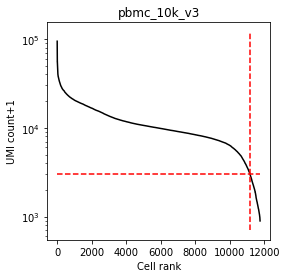

In [13]:
cf = []
thr_lb = [3e3]
fig1,ax1 = plt.subplots(1,1,figsize=(4,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k ]
    dataset_name = raw_data_locations[len(cluster_names)*k ]
    
    clusters = cluster_annotations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(clusters)
        annot_bcs_in_loom = clusters['Barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = clusters['Barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        for j,cluster in enumerate(cluster_names):
            annot_bcs = clusters[clusters['Cluster']==(j+1)]['Barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')

    ax1.set_title(dataset_name)


In [14]:
[x.sum() for x in cf]


[5339, 3933, 1641]

## Preprocessing

Create a batch and select genes to analyze.


In [15]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells
INFO:root:5339 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:4213 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells created.
INFO:root:Dataset: pbmc_10k_v3_Monocytes
INFO:root:3933 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:4645 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes created.
INFO:root:Dataset: pbmc_10k_v3_Bcells
INFO:root:1641 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:2997 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_1

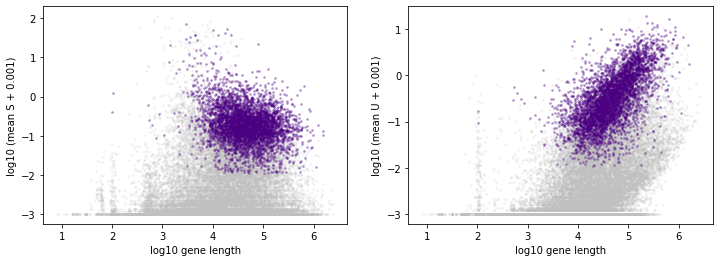

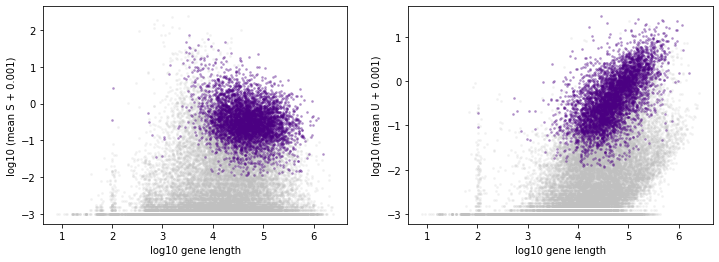

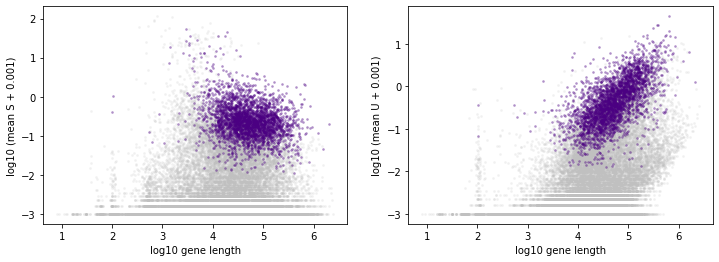

In [16]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='pbmc_celltypes',batch_id=1,\
                                             n_genes=3500,exp_filter_threshold=None,cf=cf,
                                             genes_to_fit=markers)

## Inference

Fit the model.


In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_pbmc_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [2:13:17<00:00, 19.04s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 8008.6 seconds.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Monocytes
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_pbmc_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/raw.sd.
INFO:root:Starting parallelized grid sc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:38:28<00:00, 14.07s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 5915.2 seconds.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Bcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_pbmc_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:20:51<00:00, 11.55s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 4855.2 seconds.


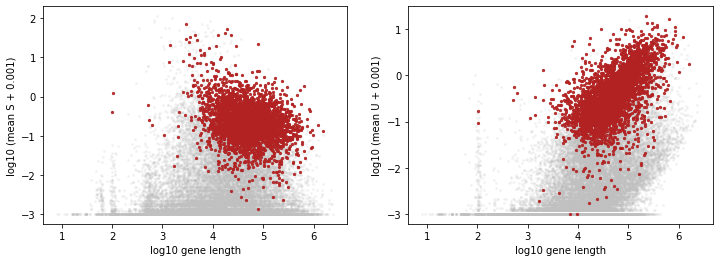

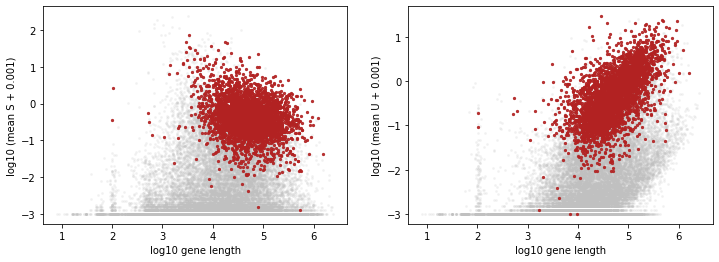

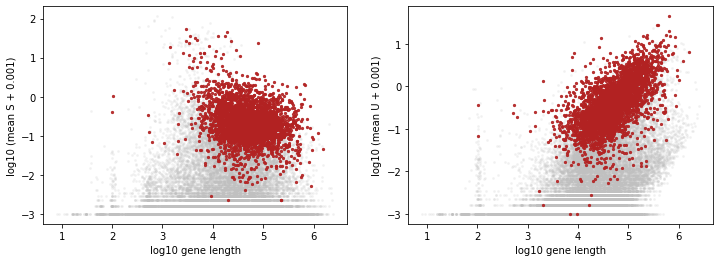

In [19]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [20,21]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(25,search_data)
    result_strings.append(full_result_string)


## Post-processing

Load in data and do basic QC: test parameter trends, KLD landscapes, and goodness-of-fit.


In [20]:
dataset_names

['pbmc_10k_v3_Tcells', 'pbmc_10k_v3_Monocytes', 'pbmc_10k_v3_Bcells']

In [21]:
dir_string

'./fits/gg_221118_025_pbmc_celltypes_1'

In [22]:
result_strings

['./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/grid_scan_results.res']

INFO:root:Grid scan results loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 43 genes out of 3500. Runtime: 13.8 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -5.63, -

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2994 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3171 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 133.6 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3447 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3458 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3474 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 79.8 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.


/home/ggorin/projects/monod/src/monod/inference.py:1003: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(nrows=1, ncols=num_params, figsize=figsize)


INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/analysis_figures already exists.


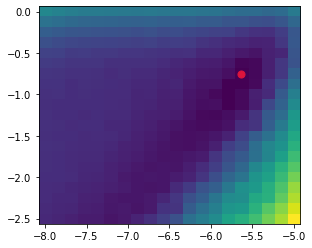

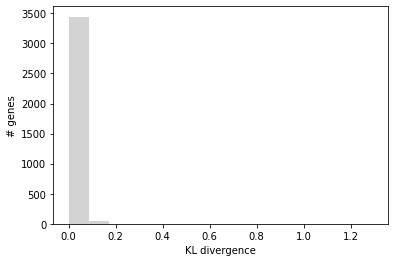

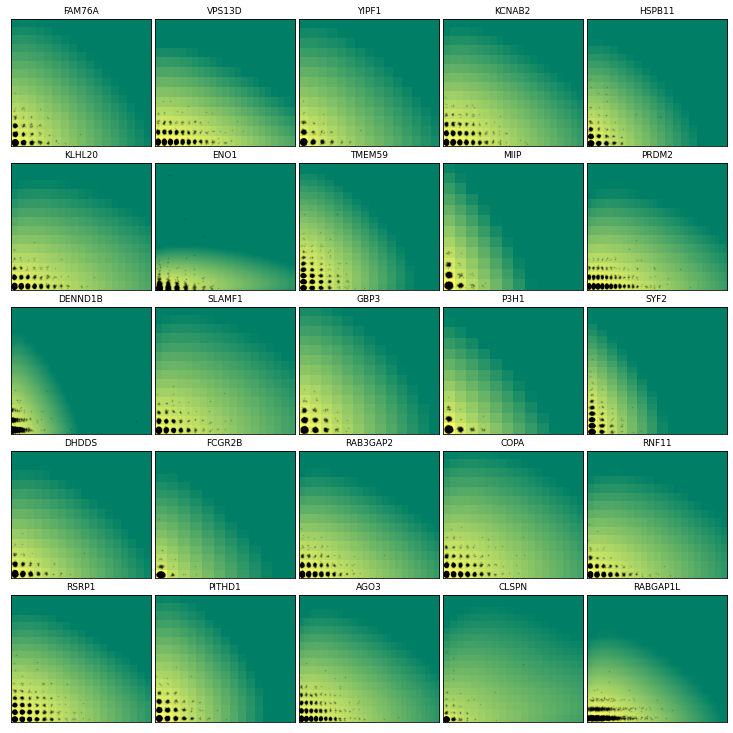

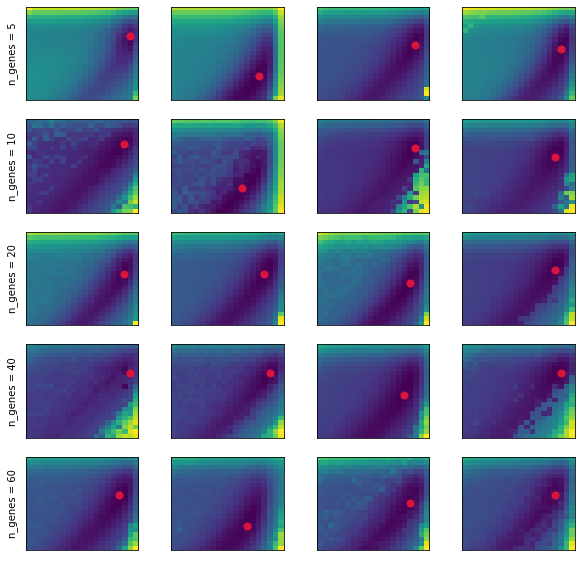

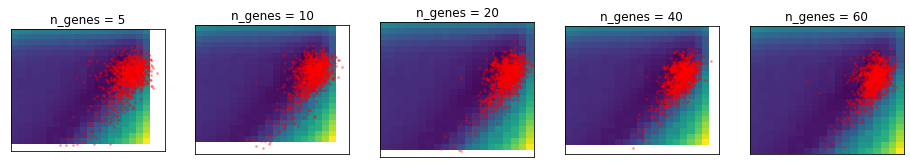

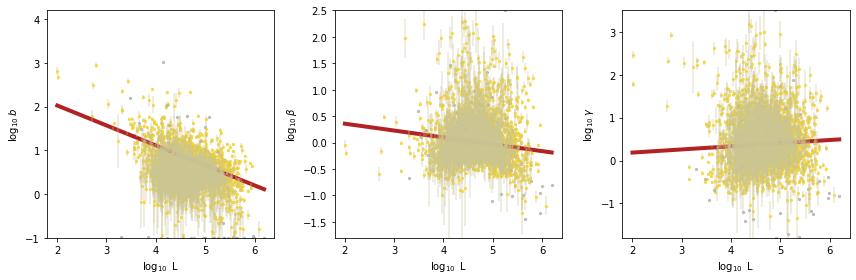

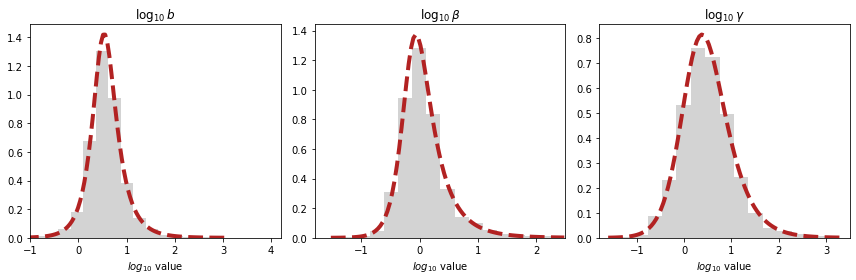

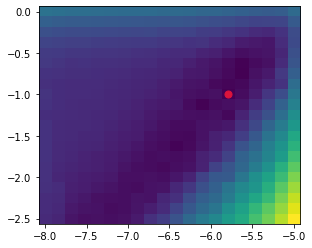

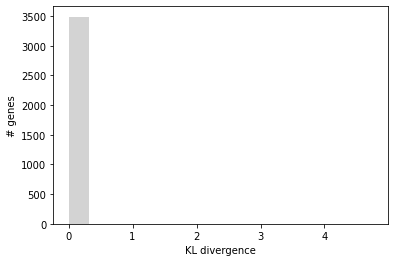

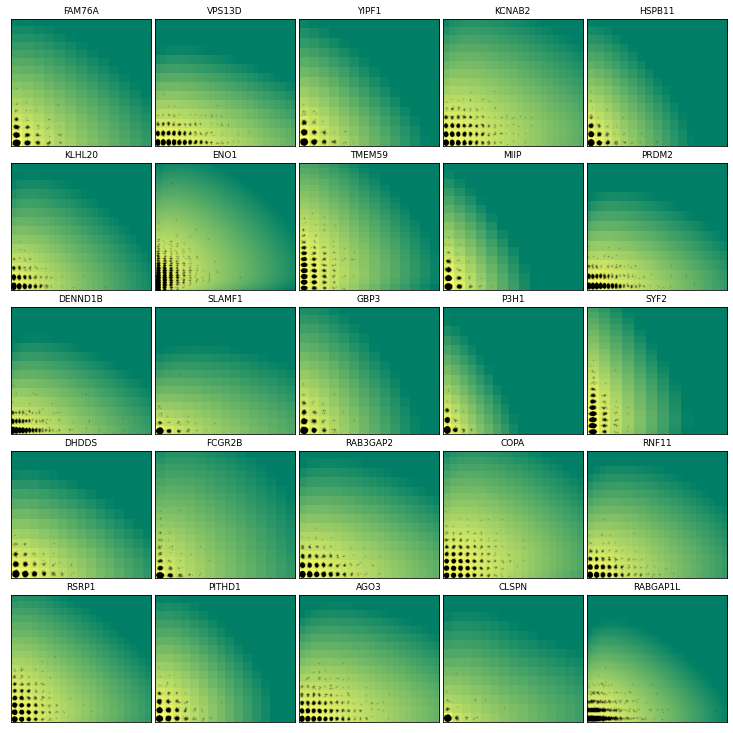

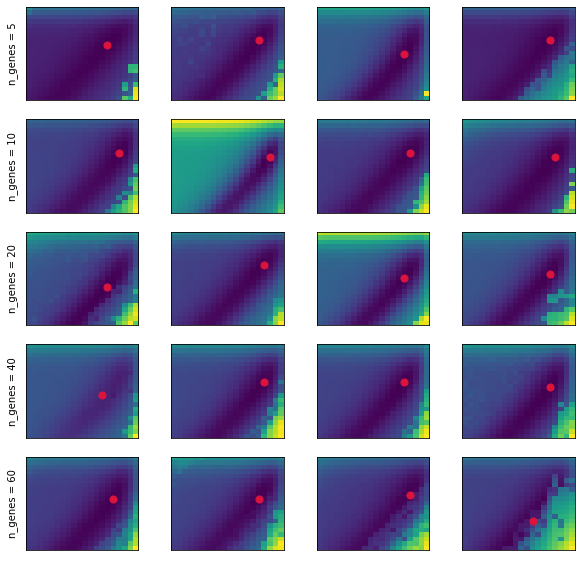

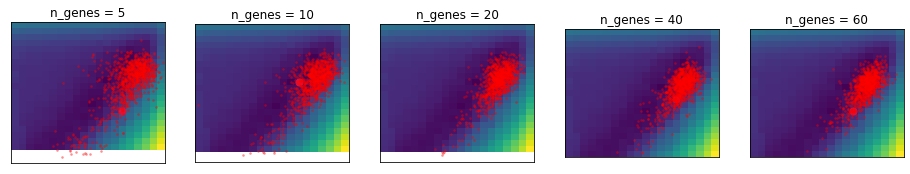

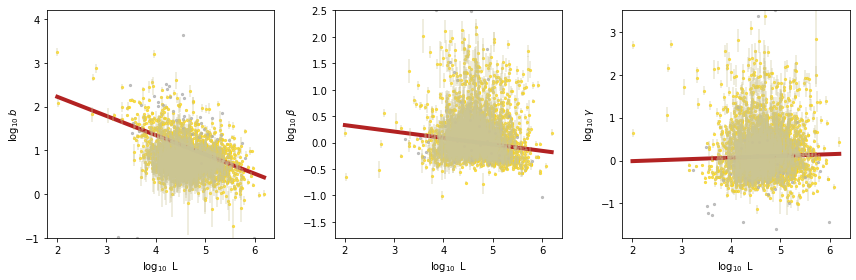

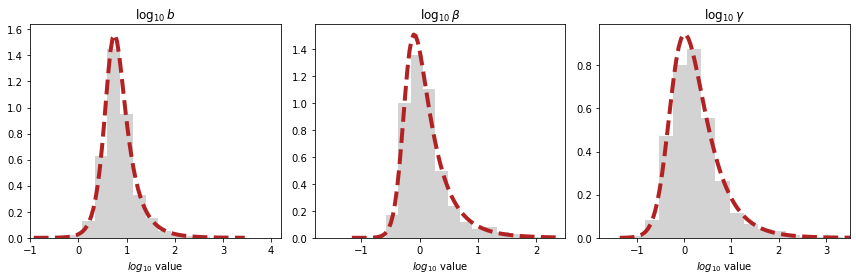

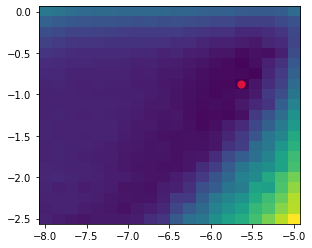

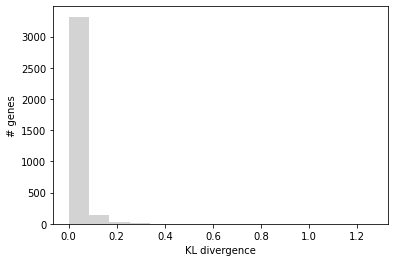

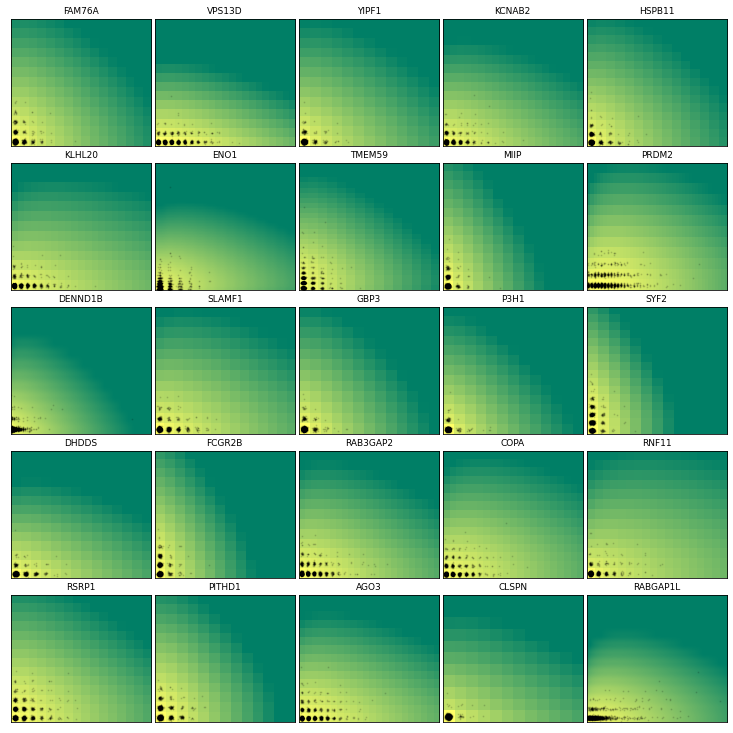

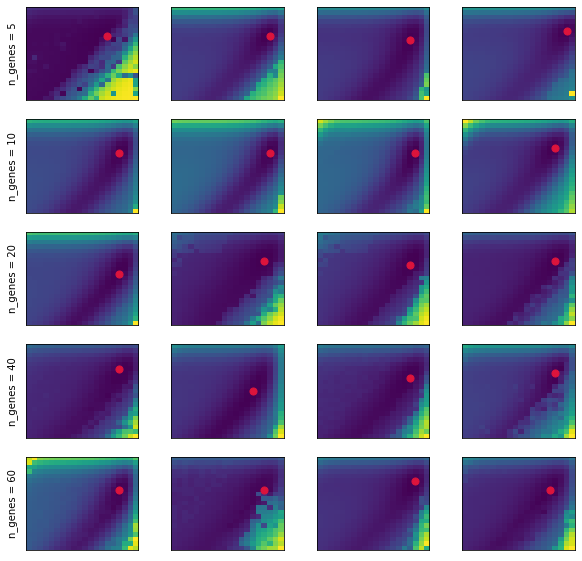

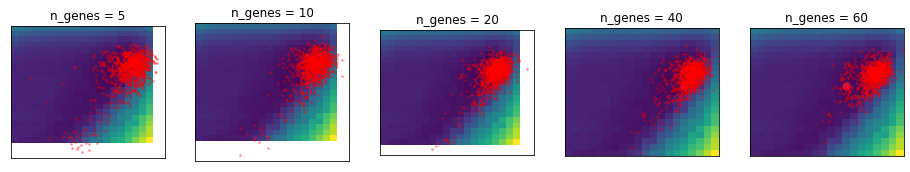

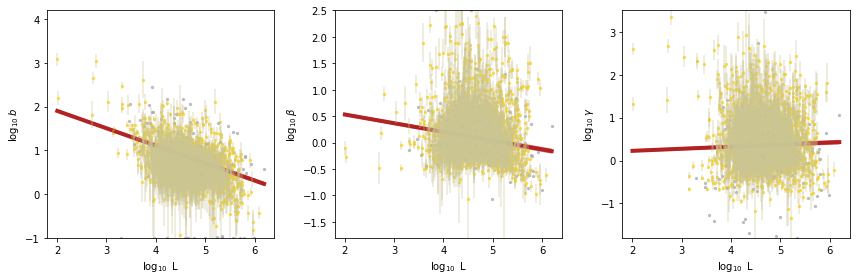

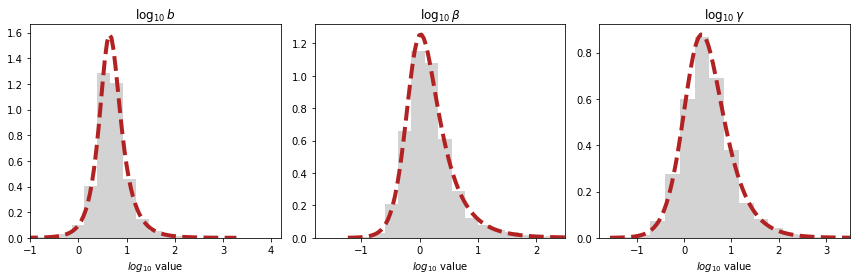

In [23]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=25)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [63]:
# dir_string = './fits/gg_221118_025_pbmc_celltypes_1'
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]